### Imports

In [0]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from matplotlib import pyplot as plt
import pandas_profiling
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from PIL import Image
from io import BytesIO
import skimage.io
import requests
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import gc
from google.colab import files
plt.style.use('seaborn')


## Data Loading, Transformation, and Splitting


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#all_housing_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_housing_data.csv')
all_housing_data = pd.read_csv('/content/drive/My Drive/AI Final Project/final_housing_data.csv') ##Alex's location

relevant_columns = ['price', 'year_built', 'square_footage', 'acreage', 'beds', 'baths', 'numRooms', 'cluster', 'description', 'photo']
housing_data = all_housing_data[relevant_columns]
print(housing_data.shape)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
(10698, 10)


In [0]:
##Loading house data for Colton's house for testing purpose

colton_housing_data = pd.read_csv('/content/drive/My Drive/AI Final Project/final_housing_data_with_test.csv') ##Alex's location

colton_numeric_data = pd.read_csv('/content/drive/My Drive/AI Final Project/colton_numeric_data1.csv')

relevant_columns = ['price', 'year_built', 'square_footage', 'acreage', 'beds', 'baths', 'numRooms', 'cluster', 'description', 'photo']
housing_data = colton_housing_data[relevant_columns]

colton_index = colton_housing_data.loc[colton_housing_data['dataset'].isin(['test - bathroom main image', 'test - bathroom main image with better description', 'test - front of house with same description', 'test - front of house with better description',
 'test - front of house with orig description', 'test - front of house with bad description', 'test - living room with orig description', 'test - living room with bad description', 'test - kitchen with orig description',
 'test - kitchen with bad description', 'test - bedroom with orig description', 'test - bedroom with bad description'])].index.tolist()

print(colton_numeric_data.shape)

(12, 477)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Colton Data: (12, 112, 112, 3)
Image size (112, 112, 3)


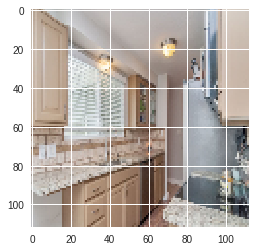

In [0]:
%matplotlib inline

#Transforming colton's data
from skimage import transform
colton_urls = colton_housing_data['photo'][colton_index].values

def getImageArray(img_url):
    response = requests.get(img_url)
    img = np.array(Image.open(BytesIO(response.content)))
    return img

def showImage(img):
    print("Image size", img.shape)
    plt.imshow(img)
    plt.show()
    
    

  
#colton_photos_array = np.zeros((12, 224, 224, 3))
colton_photos_array = np.zeros((12, 112, 112, 3))
for i,url in enumerate(colton_urls):
  colton_photos_array[i] = transform.resize(getImageArray(url), (112, 112), mode='constant')
print("Colton Data:", colton_photos_array.shape)

colton_text_description = colton_housing_data['description'][colton_index].values

showImage(colton_photos_array[8])

In [0]:
print(colton_urls)

['https://photos.zillowstatic.com/cc_ft_1536/ISma6214cuulvt0000000000.jpg'
 'https://photos.zillowstatic.com/cc_ft_1536/ISma6214cuulvt0000000000.jpg'
 'https://photos.zillowstatic.com/cc_ft_1536/ISuc5dd1d0zwwt0000000000.jpg'
 'https://photos.zillowstatic.com/cc_ft_1536/ISuc5dd1d0zwwt0000000000.jpg'
 'https://photos.zillowstatic.com/p_h/ISus9j9blfol7a1000000000.jpg'
 'https://photos.zillowstatic.com/p_h/ISus9j9blfol7a1000000000.jpg'
 'https://photos.zillowstatic.com/p_f/ISijef21m1hdwc1000000000.jpg'
 'https://photos.zillowstatic.com/p_f/ISijef21m1hdwc1000000000.jpg'
 'https://photos.zillowstatic.com/p_f/ISyrzt7j1uejoa1000000000.jpg'
 'https://photos.zillowstatic.com/p_f/ISyrzt7j1uejoa1000000000.jpg'
 'https://photos.zillowstatic.com/p_f/ISatcu9mq6s2oa1000000000.jpg'
 'https://photos.zillowstatic.com/p_f/ISatcu9mq6s2oa1000000000.jpg']


**Load images**

In [0]:
%%time
#Load images - pickle is dictionary with key as URL and value as photo array
##images = pickle.load(open('/content/drive/My Drive/images.pkl', 'rb'))
images = pickle.load(open('/content/drive/My Drive/images_small.pkl', 'rb')) ##Alex's location

CPU times: user 810 ms, sys: 3.25 s, total: 4.06 s
Wall time: 27.2 s


In [0]:
print("Number of Images:", len(images))

Number of Images: 8908


In [0]:
# #Get photo URLs from data frame
X_all_photo =  housing_data['photo']

#Go through all data rows and see if there is a valid image
all_photos = []
valid_indices = []
for i in range(0,10650):
  if X_all_photo.values[i] in images.keys():
    img_array = images.get(X_all_photo.values[i])
    if (len(img_array.shape) == 3 and img_array.shape[2] == 3):
      all_photos.append(img_array)
      valid_indices.append(i)
      
print("Valid indices", len(valid_indices))

Valid indices 8574


In [0]:
#delete images dictionary after retrieving valid photos
del images

In [0]:
# #Filter original data based on ones that have valid images
housing_data = housing_data[housing_data.index.isin(valid_indices)]


print("Removing houses with prices >$10M and < $40k")
housing_data = housing_data.drop(housing_data[(housing_data['price'] > 10000000) | (housing_data['price'] < 40000)].index)

print("\nData shape:", housing_data.shape)


Removing houses with prices >$10M and < $40k

Data shape: (8270, 10)


In [0]:
#Remove clusters with <= 5 datapoints
import collections

cluster_counts = collections.Counter(housing_data['cluster'])
clusters_to_remove = []

for val, key in zip(cluster_counts.values(), cluster_counts.keys()):
    if val <= 5:
        clusters_to_remove.append(key)

        
#print("Clusters being removed:", clusters_to_remove)
print("Number of clusters removed:", len(clusters_to_remove))

pitt_clusters = 0
ut_clusters = 0
for c in clusters_to_remove:
    if "p" in c:
        pitt_clusters += 1
    else:
        ut_clusters += 1
        
print("   Pittsburgh Clusters removed:", pitt_clusters)
print("   Utah Clusters removed:", ut_clusters)

Number of clusters removed: 75
   Pittsburgh Clusters removed: 33
   Utah Clusters removed: 42


In [0]:
# Dropping all the rows that are in the clusters with not enough data points
housing_data = housing_data[~housing_data['cluster'].isin(clusters_to_remove)]
    
housing_data.shape

(8021, 10)

**One hot encoding and split data into train and test**

In [0]:
df_dummies = pd.get_dummies(housing_data['cluster'])
cluster_cols = list(df_dummies.columns)

housing_data = housing_data.join(df_dummies)
housing_data.drop(['cluster'], axis=1, inplace=True)
del df_dummies

feature_cols = ['year_built', 'square_footage', 'acreage', 'beds', 'baths', 'numRooms'] + cluster_cols



X_train, X_test, y_train, y_test= train_test_split(housing_data[feature_cols], housing_data['price'], test_size=0.20, random_state =  100)
print("Train data size:", len(y_train))
print("Test data size:", len(y_test))

train_idx = X_train.index.tolist()
test_idx = X_test.index.tolist()

Train data size: 6416
Test data size: 1605


**Train regression model to use for data imputation**

In [0]:
from sklearn.linear_model import Ridge

#Prepare data to train Ridge regression
X_dropna = X_train[['beds', 'baths', 'square_footage', 'numRooms']].dropna()

X = X_dropna[['beds', 'baths', 'square_footage']].values
y = X_dropna['numRooms'].values


#Train model will all data
ridge = Ridge(normalize=True)
imputation_model = ridge.fit(X, y)


**Impute missing data using imputation model**

In [0]:
#fill na values
X_missing_data = X_train
imputed_count = 0

for idx in X_missing_data.index:
  
  if pd.isnull(X_missing_data.loc[idx,"numRooms"]):
    #print("\nnull value found for numRooms")
    if pd.isnull(X_missing_data.loc[idx,"beds"]) or pd.isnull(X_missing_data.loc[idx,"baths"]) or pd.isnull(X_missing_data.loc[idx,"square_footage"]):
      X_missing_data.loc[idx,"numRooms"] = None #cannot compute if an input feature is null, leave as null
      #print("input feature is also null, cannot impute value")
    
    else:
      bedrooms = X_missing_data.loc[idx,"beds"]
      bathrooms = X_missing_data.loc[idx,"baths"]
      square_footage = X_missing_data.loc[idx,"square_footage"]
      
      #print("Input features: bedrooms", bedrooms, "bathrooms", bathrooms, "square_footage", square_footage )
      #print("Predicted value: ", imputation_model.predict(np.array([bedrooms, bathrooms, numRooms]).reshape(1, -1)) )
      
      X_missing_data.loc[idx,"numRooms"] = imputation_model.predict(np.array([bedrooms, bathrooms, square_footage]).reshape(1, -1))
      imputed_count += 1
      

#print(X_missing_data.shape[0])
#print(X_missing_data.isna().sum())
nulls_index = list(X_missing_data['square_footage'].index[X_missing_data['square_footage'].apply(np.isnan)])
nulls_index += list(X_missing_data['beds'].index[X_missing_data['beds'].apply(np.isnan)])
nulls_index += list(X_missing_data['baths'].index[X_missing_data['baths'].apply(np.isnan)])
nulls_index += list(X_missing_data['numRooms'].index[X_missing_data['numRooms'].apply(np.isnan)])
nulls_index += list(X_missing_data['year_built'].index[X_missing_data['year_built'].apply(np.isnan)])
nulls_index += list(X_missing_data['acreage'].index[X_missing_data['acreage'].apply(np.isnan)])

nulls_index = list(set(nulls_index))
nulls_index.sort()

X_train_dropna = X_missing_data.dropna()
y_train_dropna = y_train.drop(nulls_index, axis=0)
#print(len(nulls_index))
#print(X_train_dropna.shape[0])


print("Before imputation and removing NAs  :", len(X_train.index))
print("Imputed values for", imputed_count, "rows")
print("\nRemoving remaining NAs...")
print("After imputation and removing NAs   :", len(X_train_dropna.index))



Before imputation and removing NAs  : 6416
Imputed values for 5081 rows

Removing remaining NAs...
After imputation and removing NAs   : 6316


**Preparing Test Data**

In [0]:
#impute NAs in test data using model trained on train data
X_missing_data = X_test

for idx in X_missing_data.index:
  if pd.isnull(X_missing_data.loc[idx,"numRooms"]):
    #print("\nnull value found for numRooms")
    if pd.isnull(X_missing_data.loc[idx,"beds"]) or pd.isnull(X_missing_data.loc[idx,"baths"]) or pd.isnull(X_missing_data.loc[idx,"square_footage"]):
      X_missing_data.loc[idx,"numRooms"] = None #cannot compute if an input feature is null, leave as null
      #print("input feature is also null, cannot impute value")
    
    else:
      bedrooms = X_missing_data.loc[idx,"beds"]
      bathrooms = X_missing_data.loc[idx,"baths"]
      square_footage = X_missing_data.loc[idx,"square_footage"]
      
      #print("Input features: bedrooms", bedrooms, "bathrooms", bathrooms, "square_footage", square_footage )
      #print("Predicted value: ", imputation_model.predict(np.array([bedrooms, bathrooms, numRooms]).reshape(1, -1)) )
      
      X_missing_data.loc[idx,"numRooms"] = imputation_model.predict(np.array([bedrooms, bathrooms, square_footage]).reshape(1, -1))
      imputed_count += 1


#remove remaining nulls after imputation
nulls_index_test = list(X_missing_data['square_footage'].index[X_missing_data['square_footage'].apply(np.isnan)])
nulls_index_test += list(X_missing_data['beds'].index[X_missing_data['beds'].apply(np.isnan)])
nulls_index_test += list(X_missing_data['baths'].index[X_missing_data['baths'].apply(np.isnan)])
nulls_index_test += list(X_missing_data['numRooms'].index[X_missing_data['numRooms'].apply(np.isnan)])
nulls_index_test += list(X_missing_data['year_built'].index[X_missing_data['year_built'].apply(np.isnan)])
nulls_index_test += list(X_missing_data['acreage'].index[X_missing_data['acreage'].apply(np.isnan)])

X_test = X_missing_data.dropna()
y_test = y_test.drop(nulls_index_test, axis=0)

y_test_log = list(np.log10(y_test))




**Scale Numerical Columns to using MinMax (except OHE columns) for all data**

Makes data in range [0,1]

In [0]:
import warnings
warnings.filterwarnings("ignore")

#Scale data with zero means (do not scale OHE columns)
scaler = MinMaxScaler()
for col in ['year_built', 'square_footage', 'acreage', 'beds', 'baths', 'numRooms']:
  X_train_dropna[col] = scaler.fit_transform(pd.DataFrame(X_train_dropna[col]))
  X_test[col] = scaler.transform(pd.DataFrame(X_test[col]))
  colton_numeric_data[col] = scaler.transform(pd.DataFrame(colton_numeric_data[col]))
  
  
#Take log of prices
y_train_log = np.log10(y_train_dropna)

In [0]:

total = []
for cluster in cluster_cols:
  total.append(X_train_dropna[cluster].max())
  
print("Clusters with no training data:", total.count(0))


Clusters with no training data: 0


In [0]:
#Final train and test indices
train_idx = X_train_dropna.index.values
test_idx = X_test.index.values

print(len(train_idx))
print(len(test_idx))


6316
1576


**Prepare image data into correctly formatted arrays **

In [0]:
##Format Train and Test data correctly for CNN input

#select num images to used based on memory constraint
num_train_images = 6300

#train_photos_array = np.zeros((num_train_images, 224, 224, 3))
train_photos_array = np.zeros((num_train_images, 112, 112, 3))
for i,idx in enumerate(train_idx[0:num_train_images]):
  train_photos_array[i] = all_photos[valid_indices.index(idx)]
print("Train Data:", train_photos_array.shape)


Train Data: (6300, 112, 112, 3)


In [0]:
num_test_images = 1500

#test_photos_array = np.zeros((num_test_images, 224, 224, 3))
test_photos_array = np.zeros((num_test_images, 112, 112, 3))
for i,idx in enumerate(test_idx[0:num_test_images]):
  test_photos_array[i] = all_photos[valid_indices.index(idx)]
print("Test Data:", test_photos_array.shape)

Test Data: (1500, 112, 112, 3)



Price: 274000
Image size (112, 112, 3)


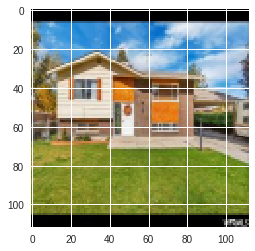


Price: 885000
Image size (112, 112, 3)


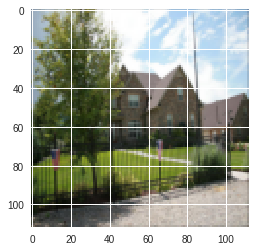


Price: 125555
Image size (112, 112, 3)


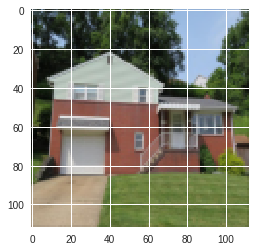


Price: 275000
Image size (112, 112, 3)


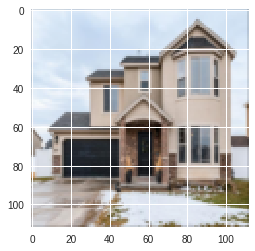


Price: 257395
Image size (112, 112, 3)


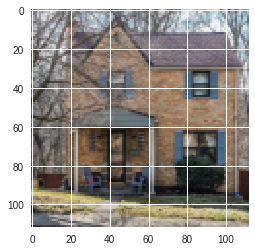


Price: 285000
Image size (112, 112, 3)


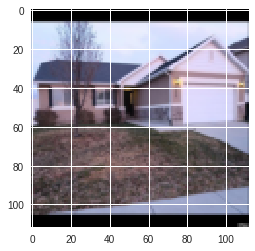


Price: 355000
Image size (112, 112, 3)


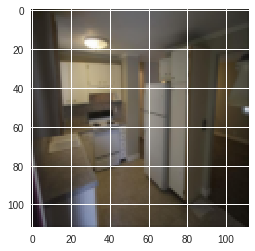


Price: 975000
Image size (112, 112, 3)


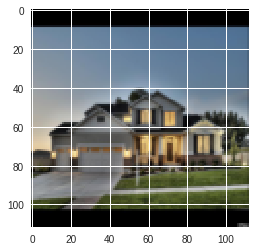


Price: 519900
Image size (112, 112, 3)


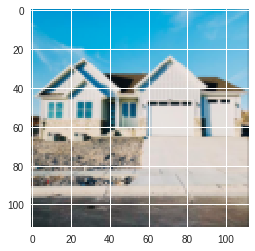


Price: 315000
Image size (112, 112, 3)


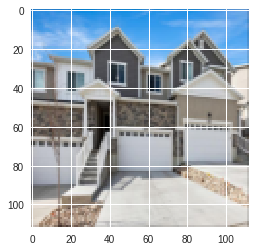


Price: 569900
Image size (112, 112, 3)


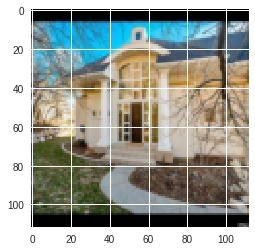


Price: 260000
Image size (112, 112, 3)


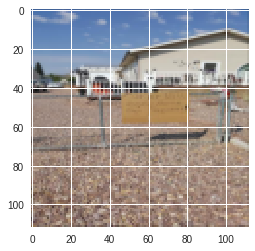


Price: 275000
Image size (112, 112, 3)


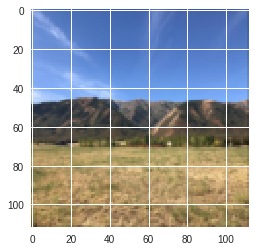


Price: 319900
Image size (112, 112, 3)


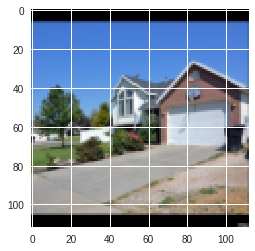


Price: 246605
Image size (112, 112, 3)


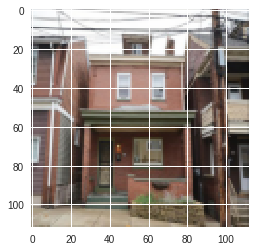


Price: 249000
Image size (112, 112, 3)


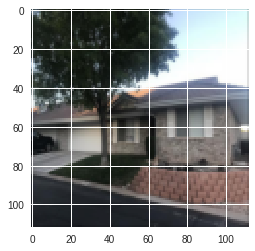


Price: 1907028
Image size (112, 112, 3)


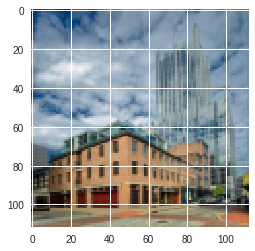


Price: 424900
Image size (112, 112, 3)


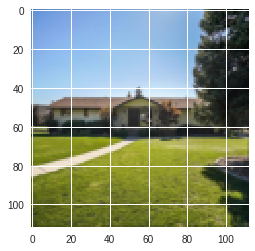


Price: 559900
Image size (112, 112, 3)


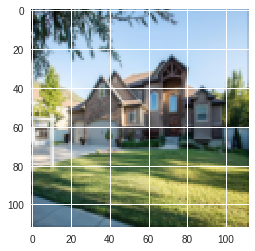


Price: 2180000
Image size (112, 112, 3)


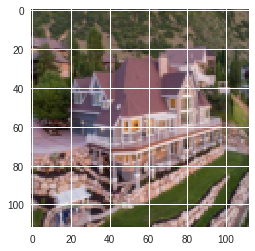


Price: 540000
Image size (112, 112, 3)


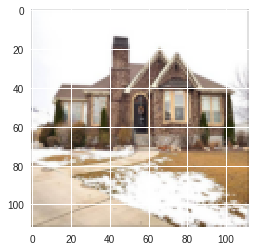


Price: 428784
Image size (112, 112, 3)


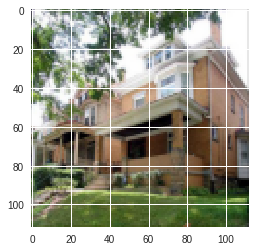


Price: 329900
Image size (112, 112, 3)


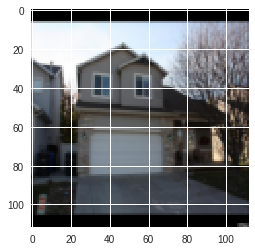


Price: 249900
Image size (112, 112, 3)


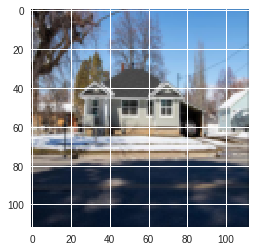


Price: 138369
Image size (112, 112, 3)


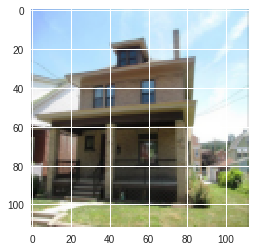


Price: 620000
Image size (112, 112, 3)


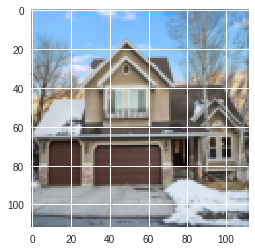


Price: 104475
Image size (112, 112, 3)


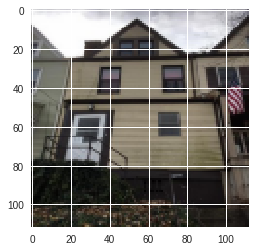


Price: 463842
Image size (112, 112, 3)


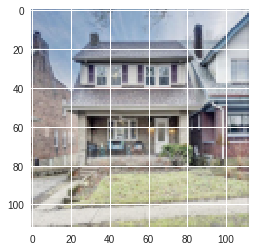


Price: 585000
Image size (112, 112, 3)


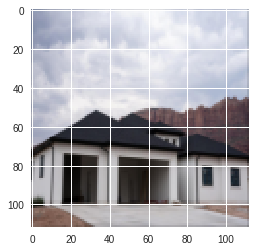


Price: 479000
Image size (112, 112, 3)


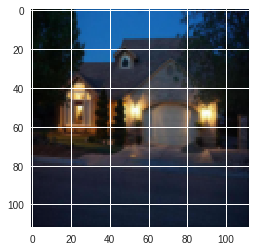


Price: 515000
Image size (112, 112, 3)


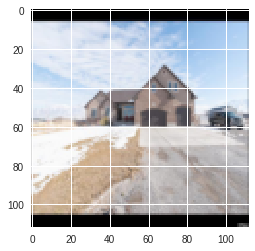


Price: 156215
Image size (112, 112, 3)


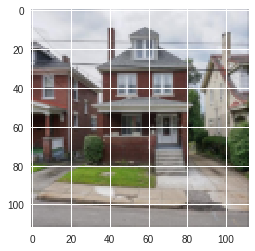


Price: 622432
Image size (112, 112, 3)


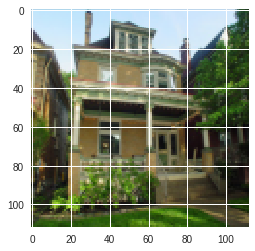


Price: 235000
Image size (112, 112, 3)


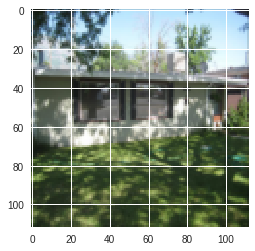


Price: 639000
Image size (112, 112, 3)


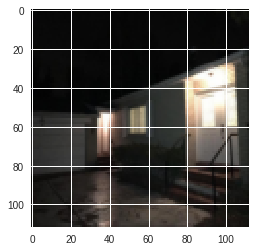


Price: 305000
Image size (112, 112, 3)


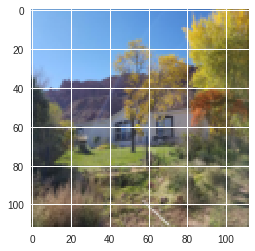


Price: 310000
Image size (112, 112, 3)


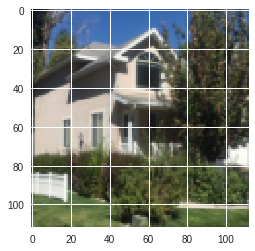


Price: 349900
Image size (112, 112, 3)


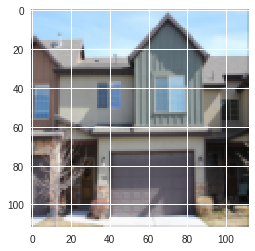


Price: 292000
Image size (112, 112, 3)


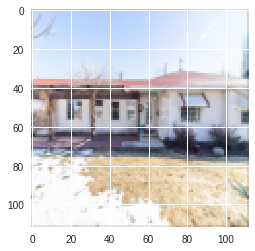


Price: 195366
Image size (112, 112, 3)


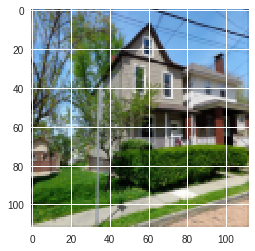

In [0]:
%matplotlib inline

for i in range(40):
  print("\nPrice:", y_train_dropna.values[i])
  showImage(train_photos_array[i])

In [0]:
del all_photos

**Prepare Text Analysis data from house descriptions**

In [0]:
import spacy

nlp = spacy.load('en', disable=['ner', 'parser', 'tagger'])
all_descriptions = ""

for index, row in all_housing_data.iterrows():
    text = str(row['description'])
    all_descriptions += text
    
nlp.max_length = 10000000
corpus_text = nlp(all_descriptions)

In [0]:
from operator import itemgetter
from collections import Counter
import re

histogram_no_stopwords = Counter()
for token in corpus_text:
    if not (token.is_stop):
        token_lemma = token.lemma_
        if token_lemma not in histogram_no_stopwords:
            if re.match('[a-zA-Z]+$', token_lemma):
                histogram_no_stopwords[token_lemma.lower()] = 1
        else:  # the token text is already a key in the dictionary so increase its value by 1
            if re.match('[a-zA-Z]+$', token_lemma):
                histogram_no_stopwords[token_lemma.lower()] = histogram_no_stopwords[token_lemma.lower()] + 1

idx = 0
sorted_lemma_count_pairs_no_stopwords = sorted(histogram_no_stopwords.items(),
                                  reverse=True,
                                  key=itemgetter(1))
print("Top 20 Word by Frequency (Stop Words Removed)")
print("-----------------------------------------------")
for lemma, count in sorted_lemma_count_pairs_no_stopwords:
    if idx < 20:
        print((idx + 1), ". ", lemma, ":", count)
        idx += 1
    else:
        break 

Top 20 Word by Frequency (Stop Words Removed)
-----------------------------------------------
1 .  locate : 1422
2 .  amaze : 784
3 .  cover : 745
4 .  vault : 709
5 .  feature : 507
6 .  dine : 494
7 .  figure : 488
8 .  stave : 473
9 .  advise : 458
10 .  ton : 409
11 .  boast : 393
12 .  install : 385
13 .  amenity : 374
14 .  rend : 362
15 .  attach : 348
16 .  detach : 343
17 .  stun : 338
18 .  renovate : 330
19 .  shelve : 306
20 .  burn : 238


In [0]:
print("Number of unique words:", len(sorted_lemma_count_pairs_no_stopwords))

Number of unique words: 13397


In [0]:
# List of each description
descriptions = []
for index, row in all_housing_data.iterrows():
    descriptions.append(str(row['description']))
    
print(descriptions[0],"\n")
print(descriptions[1], "\n")


train_descriptions = np.array(descriptions)[train_idx]
test_descriptions = np.array(descriptions)[test_idx[0:num_test_images]]

print(len(train_descriptions))
print(len(test_descriptions))

2002 home built by contractor-owner. 3300 sq/ft. newly remodeled kit. new appliances, large bonus attic rm.  5 bedrooms (one unfinished),Home office or 6th bedroom, 3.5 bath rms, family/game rm. t.v. rm, formal dining rm. open floor plan kitchen/breakfast nook/family rm. mud room.  Hardwood/tile floors. 2 gas fireplaces, Food storage rm.
 850+ sq. ft. rental apartment above two car garage that rents easily for $450/month. All hardwood/tile flooring.
1200 sq./ft. heated shop/garage out back. 

This is a beautiful oolite stone home in Manti. It is a wonderful family home, featuring 4 bedrooms, 2 1/2 baths, dining room, living room, family room, laundry room, and a large .36 acre yard with white vinyl fencing. The home features radiant hot water heating throughout utilizing a natural gas boiler. The thick rock walls keep the home cool in the summer. The large yard is augmented by many mature shade trees, a spacious lawn with a sprinkler system, a cement basketball court, and a convenien 


In [0]:
#delete unused variables

print("variables cleared:", gc.collect())


variables cleared: 243


**Final Cleaned Data for Training Models**

In [0]:
## Numerical Only Features

print("Numerical Only Features")
print("  Train Data:", X_train_dropna.shape)
print("  Train Labels:", y_train_log.shape)
print("  Test Data:", X_test.shape)
print("  Test Labels:", len(y_test_log))


print("\nImage Only Features")
print("  Train Data:", train_photos_array.shape)
print("  Train Labels:", y_train_log[0:num_train_images].shape)
print("  Train Data:", test_photos_array.shape)
print("  Test Labels:", len(y_test_log[0:num_test_images]))


print("\nText Description Only Features")
print("  Train Data:", len(train_descriptions))
print("  Train Labels:", y_train_log.shape)
print("  Train Data:", len(test_descriptions))
print("  Test Labels:", len(y_test_log[0:num_test_images]))


#Use to capture scores of all models
mse_scores = {}

Numerical Only Features
  Train Data: (6316, 477)
  Train Labels: (6316,)
  Test Data: (1576, 477)
  Test Labels: 1576

Image Only Features
  Train Data: (6300, 112, 112, 3)
  Train Labels: (6300,)
  Train Data: (1500, 112, 112, 3)
  Test Labels: 1500

Text Description Only Features
  Train Data: 6316
  Train Labels: (6316,)
  Train Data: 1500
  Test Labels: 1500


## Train Baseline Linear Regression Model

In [0]:
'''
Baseline model
Linear regression with no regularization

'''
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Train model
linRegModel = LinearRegression()
linRegModel.fit(X_train_dropna, y_train_log)

#Model predict
preds = linRegModel.predict(X_test[0:num_test_images])

#Print out weights and predictions 
#print( "Intercept", linRegModel.intercept_, "\nFeature Weights:\n", feature_cols, "\n", linRegModel.coef_)
#for i in range(len(preds)):
   #print("Truth:","{:<10}".format(str(y_test_log[i])), "Prediction:", preds[i])   

  
  
print("MSE", round(mean_squared_error(y_test_log[0:num_test_images], preds), 5))

#store error in dictionary
mse_scores['Linear Regression'] = round(mean_squared_error(y_test_log[0:num_test_images], preds), 5)

MSE 0.02512


## Neural Net (MLP) Regression Model with Numerical Features Only

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, model_from_json
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping



Using TensorFlow backend.


In [0]:
MLP_model = Sequential()

# The Input Layer :
MLP_model.add(Dense(64, kernel_initializer='normal',input_dim = X_train_dropna.shape[1], activation='linear'))

# The Hidden Layers :
MLP_model.add(Dense(64, kernel_initializer='normal',activation='linear'))
MLP_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
MLP_model.add(Dense(32, kernel_initializer='normal',activation='sigmoid'))

# The Output Layer :
MLP_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
optimizer = optimizers.adam(lr=1e-3, decay=1e-3/200)
#optimizer = optimizers.SGD(lr=0.001, momentum=0.5, decay=0, nesterov=False)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0)
#optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
MLP_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
MLP_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                30592     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 37,921
Trainable params: 37,921
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_history = MLP_model.fit(X_train_dropna, y_train_log, 
                             epochs=30, 
                             batch_size=None, 
                             validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 5052 samples, validate on 1264 samples
Epoch 1/30
5052/5052 [==============================] - 2s 360us/step - loss: 10.4913 - mean_squared_error: 10.4913 - val_loss: 1.0553 - val_mean_squared_error: 1.0553
Epoch 2/30
5052/5052 [==============================] - 1s 133us/step - loss: 0.2832 - mean_squared_error: 0.2832 - val_loss: 0.0774 - val_mean_squared_error: 0.0774
Epoch 3/30
5052/5052 [==============================] - 1s 131us/step - loss: 0.0771 - mean_squared_error: 0.0771 - val_loss: 0.0732 - val_mean_squared_error: 0.0732
Epoch 4/30
5052/5052 [==============================] - 1s 135us/step - loss: 0.0764 - mean_squared_error: 0.0764 - val_loss: 0.0731 - val_mean_squared_error: 0.0731
Epoch 5/30
5052/5052 [==============================] - 1s 132us/step - loss: 0.0763 - mean_squared_error: 0.0763 - val_loss: 0.0729 - val_mean_squared_error: 0.0729
Epoch 6/30
5052/5052 [==============================] - 1s 132us/step - 

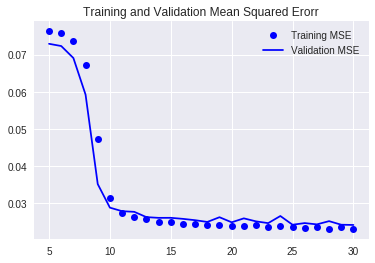

In [0]:
%matplotlib inline
mse = model_history.history['mean_squared_error']
val_mse = model_history.history['val_mean_squared_error']
epochs = range(5, len(mse)+1)
plt.plot(epochs, mse[4:], 'bo', label='Training MSE')
plt.plot(epochs, val_mse[4:], 'b', label='Validation MSE')
plt.title('Training and Validation Mean Squared Erorr')
plt.legend()
plt.show()

In [0]:
#Train NN with full data
#model_history = NN_model.fit(X_train_dropna, y_train_log, epochs=, batch_size=32, validation_split = 0, verbose = 0)


#Predict on Test data
preds = MLP_model.predict(X_test)

#Print predictions
#for i in range(len(preds)):
  #print("Truth:","{:<10}".format(str(y_test_log[i])), "Prediction:", preds[i])


print("Mean Squared Error:", round(mean_squared_error(y_test_log, preds),5))

mse_scores['MLP Numeric Only'] = round(mean_squared_error(y_test_log, preds), 5)

Mean Squared Error: 0.02725


In [0]:
#Save model

# serialize model to JSON
MLP_model_json = MLP_model.to_json()
with open("MLP_model.json", "w") as json_file:
    json_file.write(MLP_model_json)
    
files.download("MLP_model.json")    

# serialize weights to HDF5
MLP_model.save_weights("MLP_model.h5")
print("Saved model to disk")

files.download("MLP_model.h5")  m

Saved model to disk


## Neural Net (CNN) Modeling with Images Only

**Transfer Learning - Load pre-train weights from VGG19 model**

In [0]:
#Using VGG19 pretrained model from tensornets, pre-trained on 1.2million labeled images from imagenet
#model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (112, 112, 3))
#model.summary() #original VGG19 structure

In [0]:
#Freeze blocks 1-4 (layers 1-16)
#Train block 5 (layers 17-22) on our training data set
for layer in model.layers[:17]:
    layer.trainable = False

#Adding custom Layers to learn weights specific to this task 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
#x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="linear")(x) 

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "mean_squared_error", 
                    optimizer = optimizers.adam(lr=1e-3, decay=1e-3 / 200), 
                    metrics=["mean_squared_error"])

# Save the model according to the conditions  
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_mean_squared_error', min_delta=0, patience=10, verbose=1, mode='auto')


In [0]:
#Show final model layer summary with added layers
print("Model Architecture\nNumber of Layers:", len(model_final.layers))
model_final.summary()

Model Architecture
Number of Layers: 26
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 

(2, 112, 112, 3)
Image size (112, 112, 3)


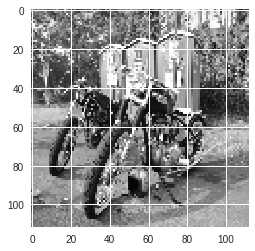

Image size (112, 112, 3)


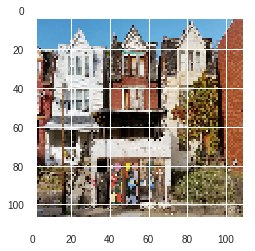

In [0]:
photos_array = np.zeros((2, 112, 112, 3))
y_target = np.array([1,0])
#y_binary = to_categorical(y_target)


%matplotlib inline
def getImageArray(img_url):
    response = requests.get(img_url)
    img = np.array(Image.open(BytesIO(response.content)))
    return img
  
image_urls = ["https://live.staticflickr.com/8040/8014131965_a567b454ea_b.jpg", "https://live.staticflickr.com/585/32396575733_ad611e5d67_k.jpg"]

  
for i,url in enumerate(image_urls):
  photos_array[i] = transform.resize(getImageArray(url), (112, 112), mode='constant')
  
print(photos_array.shape)


def showImage(img):
    print("Image size", img.shape)
    plt.imshow(img)
    plt.show()
    
    
showImage(photos_array[0])
showImage(photos_array[1])

**Train Neural Net**

In [0]:
%%time

# Training the model 
model_history = model_final.fit(
   photos_array, y_target,
    epochs = 5,
    validation_split = .2,
    batch_size = 32
    #callbacks = [checkpoint, early]
  )

Train on 1 samples, validate on 1 samples
Epoch 1/5


UnknownError: ignored

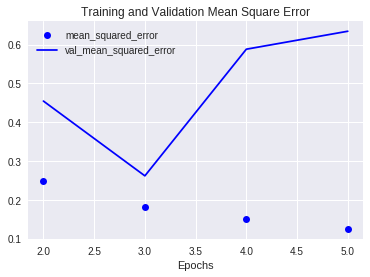

In [0]:
%matplotlib inline
# plot the accuracy rates for each epoch on training and validation data
import matplotlib.pyplot as plt
mse = model_history.history['mean_squared_error']
val_mse = model_history.history['val_mean_squared_error']
epochs = range(2, len(mse) + 1)
plt.plot(epochs, mse[1:], 'bo', label='mean_squared_error')
plt.plot(epochs, val_mse[1:], 'b', label='val_mean_squared_error')
plt.title('Training and Validation Mean Square Error')
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [0]:
preds = model_final.predict(test_photos_array[0:200])

#Print predictions
print("First 10 predictions and their truths")
for i in range(10):
  print("Truth:","{:<10}".format(str(10**y_test_log[i])), "Prediction:", 10**preds[i])

print("Mean Squared Error:", round(mean_squared_error(y_test_log[0:200], preds),5))



First 10 predictions and their truths
Truth: 829999.9999999997 Prediction: [439800.5]
Truth: 310000.0000000003 Prediction: [120404.625]
Truth: 320000.00000000023 Prediction: [246835.66]
Truth: 449999.0000000004 Prediction: [257332.31]
Truth: 165740.0000000001 Prediction: [184735.98]
Truth: 170000.00000000006 Prediction: [234539.95]
Truth: 393999.99999999965 Prediction: [519309.16]
Truth: 628000.0000000006 Prediction: [311295.7]
Truth: 377899.99999999965 Prediction: [719320.8]
Truth: 423799.99999999965 Prediction: [188191.72]
Mean Squared Error: 0.09247


In [0]:
print("Mean Squared Error:", round(mean_squared_error(y_test_log[0:200], preds),5))

Mean Squared Error: 0.09247


In [0]:
mse_scores['CNN Images only'] = round(mean_squared_error(y_test_log[0:200], preds), 5)

In [0]:
#Save model

# serialize model to JSON
CNN_model_json = model_final.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(CNN_model_json)
    
files.download("CNN_model.json")    

# serialize weights to HDF5
model_final.save_weights("CNN_model.h5")
print("Saved model to disk")

files.download("CNN_model.h5")  

Saved model to disk


## Neural Net (LSTM) Model with Description Text Only

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

NUM_WORDS = 3500 
MAX_PADDED_LENGTH = 250 #250
EPOCHS = 12

tokenizer_train = Tokenizer(num_words = NUM_WORDS)
tokenizer_train.fit_on_texts(train_descriptions)

X_sequences_train = tokenizer_train.texts_to_sequences(train_descriptions)
X_sequences_test = tokenizer_train.texts_to_sequences(test_descriptions)

In [0]:
X_padded_train = pad_sequences(X_sequences_train, maxlen = MAX_PADDED_LENGTH)
print(X_padded_train.shape)

X_padded_test = pad_sequences(X_sequences_test, maxlen = MAX_PADDED_LENGTH)
print(X_padded_test.shape)

(6316, 250)
(1500, 250)


In [0]:
from keras.layers import SimpleRNN, Dense, Embedding, LSTM
from keras.models import Sequential

model_LSTM = Sequential()
model_LSTM.add(Embedding(NUM_WORDS, input_length = MAX_PADDED_LENGTH , output_dim = 100))

LSTM_model = LSTM(64)
model_LSTM.add(LSTM_model)
model_LSTM.add(Dense(64, activation = 'relu'))
model_LSTM.add(Dense(32, activation = 'relu'))
model_LSTM.add(Dropout(0.1))

dense_layer = Dense(1, activation = "linear")
model_LSTM.add(dense_layer)

model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          350000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 398,513
Trainable params: 398,513
Non-trainable params: 0
_________________________________________________________________


In [1]:
optimizer = optimizers.adam(lr=1e-3, decay=1e-3/200)
#optimizer = optimizers.SGD(lr=0.001, momentum=0.5, decay=0, nesterov=False)
#optimizer = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0)
#optimizer = optimizers.Adagrad(lr=0.1, epsilon=None, decay=0.001)
model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

NameError: ignored

In [0]:
print(X_padded_train.shape)
print(len(y_train_log))

fitted_model = model_LSTM.fit(X_padded_train, y_train_log, 
                         validation_split=0.2, 
                         epochs=6, 
                         batch_size=32)

(6316, 250)
6316
Train on 5052 samples, validate on 1264 samples
Epoch 1/6
5052/5052 [==============================] - 40s 8ms/step - loss: 0.2304 - mean_squared_error: 0.2304 - val_loss: 0.1101 - val_mean_squared_error: 0.1101
Epoch 2/6
5052/5052 [==============================] - 40s 8ms/step - loss: 0.2219 - mean_squared_error: 0.2219 - val_loss: 0.1018 - val_mean_squared_error: 0.1018
Epoch 3/6
5052/5052 [==============================] - 40s 8ms/step - loss: 0.2291 - mean_squared_error: 0.2291 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 4/6
5052/5052 [==============================] - 40s 8ms/step - loss: 0.2278 - mean_squared_error: 0.2278 - val_loss: 0.1037 - val_mean_squared_error: 0.1037
Epoch 5/6
5052/5052 [==============================] - 41s 8ms/step - loss: 0.2228 - mean_squared_error: 0.2228 - val_loss: 0.0790 - val_mean_squared_error: 0.0790
Epoch 6/6
5052/5052 [==============================] - 41s 8ms/step - loss: 0.2154 - mean_squared_error: 0.2154 - v

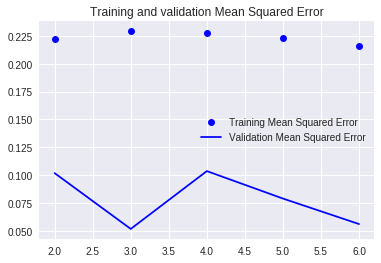

In [0]:
%matplotlib inline
acc = fitted_model.history['mean_squared_error']
val_acc = fitted_model.history['val_mean_squared_error']
epochs = range(2, len(acc)+1)
plt.plot(epochs, acc[1:], 'bo', label='Training Mean Squared Error')
plt.plot(epochs, val_acc[1:], 'b', label='Validation Mean Squared Error')
plt.title('Training and validation Mean Squared Error')
plt.legend()
plt.show()

In [0]:
preds = model_LSTM.predict(X_padded_test)
print("Mean Squared Error:", round(mean_squared_error(y_test_log[0:num_test_images], preds),5))



Mean Squared Error: 0.0513


In [0]:
mse_scores['LSTM Text only'] = round(mean_squared_error(y_test_log[0:num_test_images], preds), 5)

In [0]:
#Save model

# serialize model to JSON
LSTM_model_json = model_LSTM.to_json()
with open("LSTM_model.json", "w") as json_file:
    json_file.write(LSTM_model_json)
    
files.download("LSTM_model.json")    

# serialize weights to HDF5
model_LSTM.save_weights("LSTM_model.h5")
print("Saved model to disk")

files.download("LSTM_model.h5")  

Saved model to disk


In [0]:
print(mse_scores)

{'Linear Regression': 0.02512, 'MLP Numeric Only': 0.02805, 'CNN Images only': 0.09247, 'LSTM Text only': 0.0513, 'Combined Model': 0.02437}


## Create Combined Multi-Input Neural Net

Create three separate neural nets for numeric, text, and image data. Instead of a linear output layer for regression, leave a fully connected layer, which will be combined and then an added linear single neuron output layer.

** Textual features neural net (MLP)**

In [0]:
MLP_numeric_model = Sequential()


# The Input Layer :
MLP_numeric_model.add(Dense(64, kernel_initializer='normal',input_dim = X_train_dropna.shape[1], activation='linear'))

# The Hidden Layers :
MLP_numeric_model.add(Dense(64, kernel_initializer='normal',activation='linear'))
MLP_numeric_model.add(Dense(32, kernel_initializer='normal',activation='relu'))

#Fully connected output layer to be combined with images model
MLP_numeric_model.add(Dense(32, kernel_initializer='normal',activation='tanh'))



**Image neural net (CNN)**

In [0]:
#Load pre-trained model weights
#CNN_image_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))
CNN_image_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (112, 112, 3))

#Freeze blocks 1-4 (layers 1-16)
#Train block 5 (layers 17-22) on our training data set
for layer in CNN_image_model.layers[:18]:
    layer.trainable = False

#Adding custom Layers to learn weights specific to this task 
x = CNN_image_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(32, activation="sigmoid")(x) 

# creating the final model 
CNN_image_model_final = Model(inputs = CNN_image_model.input, outputs = predictions)


**Text Description neural net (LSTM)**

In [0]:
LSTM_text_model = Sequential()
LSTM_text_model.add(Embedding(NUM_WORDS, input_length = MAX_PADDED_LENGTH , output_dim = 100))

LSTM_model = LSTM(64)
LSTM_text_model.add(LSTM_model)
LSTM_text_model.add(Dense(64, activation = 'relu'))
LSTM_text_model.add(Dense(32, activation = 'relu'))


**Combined outputs of individual models**

In [0]:
from keras.layers import concatenate

print(MLP_numeric_model.output)
print(CNN_image_model_final.output)
print(LSTM_text_model.output)

combinedInput = concatenate([MLP_numeric_model.output, CNN_image_model_final.output, LSTM_text_model.output])

x = Dense(16, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

final_combined_model = Model(inputs=[MLP_numeric_model.input, CNN_image_model_final.input, LSTM_text_model.input ], outputs = x)

optimizer = optimizers.adam(lr=1e-3, decay=1e-3/200)
final_combined_model.compile(loss="mean_squared_error", optimizer=optimizer,  metrics=["mean_squared_error"])

final_combined_model.summary()

Tensor("dense_24/Tanh:0", shape=(?, 32), dtype=float32)
Tensor("dense_27/Sigmoid:0", shape=(?, 32), dtype=float32)
Tensor("dense_29/Relu:0", shape=(?, 32), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 112, 112, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None

In [0]:
#Train the model
combined_model_history = final_combined_model.fit(
    [X_train_dropna[2000:2400], train_photos_array[2000:2400], X_padded_train[2000:2400]], y_train_log[2000:2400],
    epochs = 10,
    validation_split = 0.15,
    batch_size = 32)


Train on 340 samples, validate on 60 samples
Epoch 1/10
340/340 [==============================] - 83s 244ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 2/10
340/340 [==============================] - 88s 258ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 3/10
340/340 [==============================] - 88s 258ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 4/10
340/340 [==============================] - 88s 258ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 5/10
340/340 [==============================] - 87s 257ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 6/10
340/340 [==============================] - 88s 258ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.021

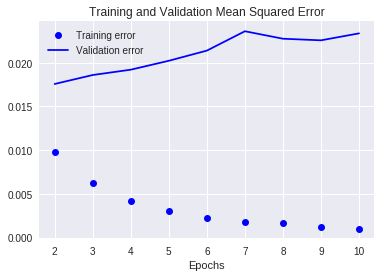

In [0]:
%matplotlib inline
# plot the accuracy rates for each epoch on training and validation data
import matplotlib.pyplot as plt
mse = combined_model_history.history['mean_squared_error']
val_mse = combined_model_history.history['val_mean_squared_error']
epochs = range(2, len(mse) + 1)
plt.plot(epochs, mse[1:], 'bo', label='Training error')
plt.plot(epochs, val_mse[1:], 'b', label='Validation error')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Results - Predict on Test Data

In [0]:
#Predict on the test data with the combined model
%%time
# print("\nTest Data Size")
# print(len(test_photos_array))
# print(len(X_test[0:num_test_images]))
# print(len(X_padded_train[0:num_test_images]))

preds = final_combined_model.predict([X_test[0:200], test_photos_array[0:200], X_padded_test[0:200]])


#Print Predictions
#for i in range(len(predictions)):
  #print("Truth:","{:<10}".format(str(y_test_log[i])), "Prediction:", preds[i])
print("Mean Squared Error:", round(mean_squared_error(y_test_log[0:num_test_images], preds),5))
mse_scores['Combined Model'] = round(mean_squared_error(y_test_log[0:num_test_images], preds), 5)

In [0]:
print("Mean Squared Error:", round(mean_squared_error(y_test_log[0:200], preds),5))
mse_scores['Combined Model'] = round(mean_squared_error(y_test_log[0:200], preds), 5)

Mean Squared Error: 0.02437


In [0]:
#Save model

# serialize model to JSON
combined_model_json = final_combined_model.to_json()
with open("Combined_model.json", "w") as json_file:
    json_file.write(combined_model_json)
    
files.download("Combined_model.json")    

# serialize weights to HDF5
final_combined_model.save_weights("Combined_model.h5")
print("Saved model to disk")

files.download("Combined_model.h5")  

Saved model to disk


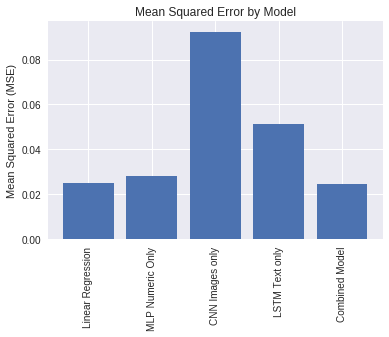

Linear Regression    MSE: 0.02512
MLP Numeric Only     MSE: 0.02805
CNN Images only      MSE: 0.09247
LSTM Text only       MSE: 0.0513
Combined Model       MSE: 0.02437


In [0]:
%matplotlib inline
#Plot MSE for each model

plt.bar(mse_scores.keys(), mse_scores.values())
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Mean Squared Error by Model")
plt.xticks(list(mse_scores.keys()), rotation='vertical')
plt.show()

for model, mse in mse_scores.items():
  print("{:20s}".format(model), "MSE:", mse)

## Load Saved Model Finals

In [0]:
# load json and create model
json_file = open('/content/drive/My Drive/AI Final Project/LSTM_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
LSTM_loaded_model = model_from_json(loaded_model_json)

# load weights into new model
LSTM_loaded_model.load_weights("/content/drive/My Drive/AI Final Project/LSTM_model.h5")
print("Loaded LSTM model from disk")



Loaded LSTM model from disk


In [0]:
# load json and create model
json_file = open('/content/drive/My Drive/AI Final Project/MLP_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
MLP_loaded_model = model_from_json(loaded_model_json)

# load weights into new model
MLP_loaded_model.load_weights("/content/drive/My Drive/AI Final Project/MLP_model.h5")
print("Loaded MLP model from disk")



Loaded MLP model from disk


In [0]:
# load json and create model
json_file = open('/content/drive/My Drive/AI Final Project/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
CNN_loaded_model = model_from_json(loaded_model_json)

# load weights into new model
CNN_loaded_model.load_weights("/content/drive/My Drive/AI Final Project/CNN_model.h5")
print("Loaded CNN model from disk")

Loaded CNN model from disk


In [0]:
# load json and create model
json_file = open('/content/drive/My Drive/AI Final Project/Combined_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
Combined_model_loaded_model = model_from_json(loaded_model_json)

# load weights into new model
Combined_model_loaded_model.load_weights("/content/drive/My Drive/AI Final Project/Combined_model.h5")
print("Loaded Combined model from disk")

Loaded Combined model from disk


##View Example Test Outputs

In [0]:
#Use data from Colton's house to see how the predictions change with different images and text information


#convert text to padded sequence
X_sequences_colton = tokenizer_train.texts_to_sequences(colton_text_description)
X_padded_colton = pad_sequences(X_sequences_colton, maxlen = MAX_PADDED_LENGTH)


print(len(colton_photos_array))
print(len(colton_text_description))
print(len(colton_numeric_data))

12
12
12


**Predict Numeric Only Data**

In [0]:
preds = MLP_loaded_model.predict(colton_numeric_data)

for pred in preds:
  print("Prediction:", round(10**pred[0],2))

Prediction: 230113.35
Prediction: 230113.35
Prediction: 230113.35
Prediction: 230113.35
Prediction: 397676.33
Prediction: 397676.33
Prediction: 397676.33
Prediction: 397676.33
Prediction: 397676.33
Prediction: 397676.33
Prediction: 397676.33
Prediction: 397676.33


**Predict Image Only Data**

Image size (112, 112, 3)


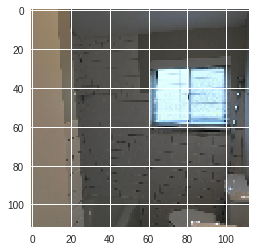

Prediction: 147009.86 


Image size (112, 112, 3)


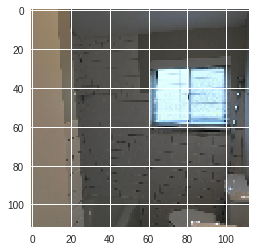

Prediction: 147009.86 


Image size (112, 112, 3)


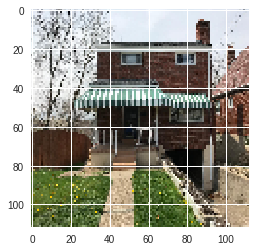

Prediction: 259464.1 


Image size (112, 112, 3)


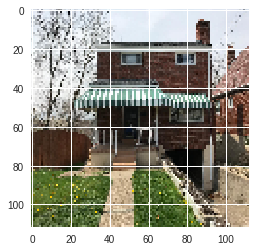

Prediction: 259464.1 


Image size (112, 112, 3)


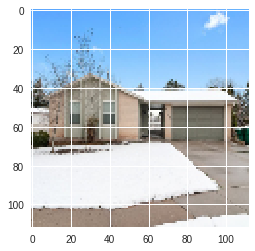

Prediction: 195421.02 


Image size (112, 112, 3)


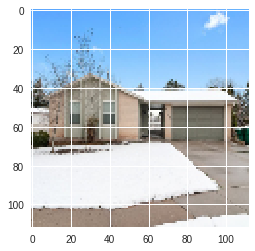

Prediction: 195421.02 


Image size (112, 112, 3)


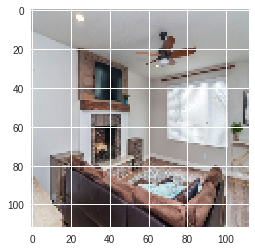

Prediction: 169972.86 


Image size (112, 112, 3)


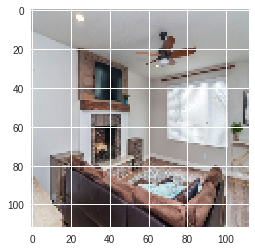

Prediction: 169972.86 


Image size (112, 112, 3)


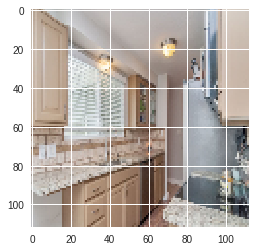

Prediction: 92835.04 


Image size (112, 112, 3)


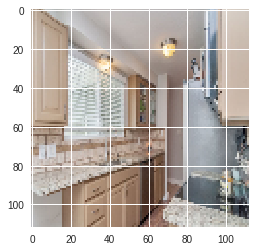

Prediction: 92835.04 


Image size (112, 112, 3)


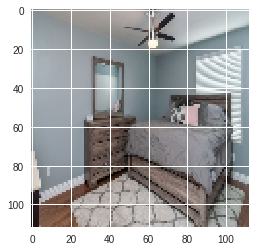

Prediction: 102032.61 


Image size (112, 112, 3)


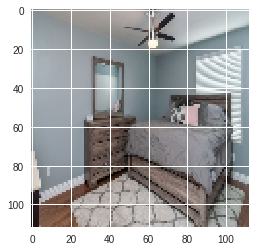

Prediction: 102032.61 




In [0]:
%matplotlib inline
preds = CNN_loaded_model.predict(colton_photos_array)

for i,pred in enumerate(preds):
  showImage(colton_photos_array[i])
  print("Prediction:", round((10**pred[0]), 2),"\n\n")

**Predict Text Only Data**

In [0]:
preds = LSTM_loaded_model.predict(X_padded_colton)

print("Text Only Descriptions")
for i,pred in enumerate(preds):
  print(colton_text_description[i])
  print("Prediction:", round(10**pred[0],2), "\n")


Text Only Descriptions
Great location Updated Great back yard and deck On and off street parking with new garage door opener Tenant pays all utilities
Prediction: 133501.13 

Awesome location! Very close to Carnegie Mellon University shuttle stop.  Quiet neighborhood with great neighbors.  Granite countertops.  Stainless steel appliances.  Newly renovated.  Brand new, updated bathroom.  Fireplace. Updated AC and Heat.  Awesome view of downtown.  Picnic table and porch overlooks nearby park and baseball field.
Prediction: 248178.38 

Great location Updated Great back yard and deck On and off street parking with new garage door opener Tenant pays all utilities
Prediction: 133501.13 

Awesome location! Very close to Carnegie Mellon University shuttle stop.  Quiet neighborhood with great neighbors.  Granite countertops.  Stainless steel appliances.  Newly renovated.  Brand new, updated bathroom.  Fireplace. Updated AC and Heat.  Awesome view of downtown.  Picnic table and porch overlooks n

**Predict All Data with the Combined Model**

In [0]:
colton_preds = Combined_model_loaded_model.predict([colton_numeric_data, colton_photos_array, X_padded_colton])

print("All Data Combined Model Predictions")
for i,pred in enumerate(colton_preds):
  print("Prediction:", round(10**pred[0],2))

All Data Combined Model Predictions
Prediction: 159381.14
Prediction: 223382.47
Prediction: 159381.14
Prediction: 223382.47
Prediction: 404007.59
Prediction: 401922.82
Prediction: 404007.59
Prediction: 401922.82
Prediction: 404007.59
Prediction: 401922.82
Prediction: 404007.59
Prediction: 401922.82
